In [ ]:
%%capture
pip install --upgrade tensorflow==2.11.0

In [1]:
# Surpress warnings from using older version of sklearn:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout

from sklearn.metrics import median_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from matplotlib.patches import ConnectionPatch

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [4]:
train = pd.read_csv('/kaggle/input/flood-dataset/train.csv')
test = pd.read_csv("/kaggle/input/flood-dataset/test.csv")


In [5]:
train.head()

id  MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
0   0                 5                   8                5              8   
1   1                 6                   7                4              4   
2   2                 6                   5                6              7   
3   3                 3                   4                6              5   
4   4                 5                   3                2              6   

   Urbanization  ClimateChange  DamsQuality  Siltation  AgriculturalPractices  \
0             6              4            4          3                      3   
1             8              8            3          5                      4   
2             3              7            1          5                      4   
3             4              8            4          7                      6   
4             4              4            3          3                      3   

   ...  DrainageSystems  CoastalVulnerability  Landslides  Watersheds  \
0  ...                5                     3           3           5   
1  ...                7                     2           0           3   
2  ...                7                     3           7           5   
3  ...                2                     4           7           4   
4  ...                2                     2           6           6   

   DeterioratingInfrastructure  PopulationScore  WetlandLoss  \
0                            4                7            5   
1                            5                3            3   
2                            6                8            2   
3                            4                6            5   
4                            4                1            2   

   InadequatePlanning  PoliticalFactors  FloodProbability  
0                   7                 3             0.445  
1                   4                 3             0.450  
2                   3                 3             0.530  
3                   7                 5             0.535  
4                   3                 5             0.415  

[5 rows x 22 columns]

In [6]:
train = train.drop(['id'],axis=1)
test = test.drop(['id'],axis=1)

In [6]:
train.describe()

id  MonsoonIntensity  TopographyDrainage  RiverManagement  \
count  1.117957e+06      1.117957e+06        1.117957e+06     1.117957e+06   
mean   5.589780e+05      4.921450e+00        4.926671e+00     4.955322e+00   
std    3.227265e+05      2.056387e+00        2.093879e+00     2.072186e+00   
min    0.000000e+00      0.000000e+00        0.000000e+00     0.000000e+00   
25%    2.794890e+05      3.000000e+00        3.000000e+00     4.000000e+00   
50%    5.589780e+05      5.000000e+00        5.000000e+00     5.000000e+00   
75%    8.384670e+05      6.000000e+00        6.000000e+00     6.000000e+00   
max    1.117956e+06      1.600000e+01        1.800000e+01     1.600000e+01   

       Deforestation  Urbanization  ClimateChange   DamsQuality     Siltation  \
count   1.117957e+06  1.117957e+06   1.117957e+06  1.117957e+06  1.117957e+06   
mean    4.942240e+00  4.942517e+00   4.934093e+00  4.955878e+00  4.927791e+00   
std     2.051689e+00  2.083391e+00   2.057742e+00  2.083063e+00  2.065992e+00   
min     0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00  0.000000e+00   
25%     4.000000e+00  3.000000e+00   3.000000e+00  4.000000e+00  3.000000e+00   
50%     5.000000e+00  5.000000e+00   5.000000e+00  5.000000e+00  5.000000e+00   
75%     6.000000e+00  6.000000e+00   6.000000e+00  6.000000e+00  6.000000e+00   
max     1.700000e+01  1.700000e+01   1.700000e+01  1.600000e+01  1.600000e+01   

       AgriculturalPractices  ...  DrainageSystems  CoastalVulnerability  \
count           1.117957e+06  ...     1.117957e+06          1.117957e+06   
mean            4.942619e+00  ...     4.946893e+00          4.953999e+00   
std             2.068545e+00  ...     2.072333e+00          2.088899e+00   
min             0.000000e+00  ...     0.000000e+00          0.000000e+00   
25%             3.000000e+00  ...     4.000000e+00          3.000000e+00   
50%             5.000000e+00  ...     5.000000e+00          5.000000e+00   
75%             6.000000e+00  ...     6.000000e+00          6.000000e+00   
max             1.600000e+01  ...     1.700000e+01          1.700000e+01   

         Landslides    Watersheds  DeterioratingInfrastructure  \
count  1.117957e+06  1.117957e+06                 1.117957e+06   
mean   4.931376e+00  4.929032e+00                 4.925907e+00   
std    2.078287e+00  2.082395e+00                 2.064813e+00   
min    0.000000e+00  0.000000e+00                 0.000000e+00   
25%    3.000000e+00  3.000000e+00                 3.000000e+00   
50%    5.000000e+00  5.000000e+00                 5.000000e+00   
75%    6.000000e+00  6.000000e+00                 6.000000e+00   
max    1.600000e+01  1.600000e+01                 1.700000e+01   

       PopulationScore   WetlandLoss  InadequatePlanning  PoliticalFactors  \
count     1.117957e+06  1.117957e+06        1.117957e+06      1.117957e+06   
mean      4.927520e+00  4.950859e+00        4.940587e+00      4.939004e+00   
std       2.074176e+00  2.068696e+00        2.081123e+00      2.090350e+00   
min       0.000000e+00  0.000000e+00        0.000000e+00      0.000000e+00   
25%       3.000000e+00  4.000000e+00        3.000000e+00      3.000000e+00   
50%       5.000000e+00  5.000000e+00        5.000000e+00      5.000000e+00   
75%       6.000000e+00  6.000000e+00        6.000000e+00      6.000000e+00   
max       1.800000e+01  1.900000e+01        1.600000e+01      1.600000e+01   

       FloodProbability  
count      1.117957e+06  
mean       5.044803e-01  
std        5.102610e-02  
min        2.850000e-01  
25%        4.700000e-01  
50%        5.050000e-01  
75%        5.400000e-01  
max        7.250000e-01  

[8 rows x 22 columns]

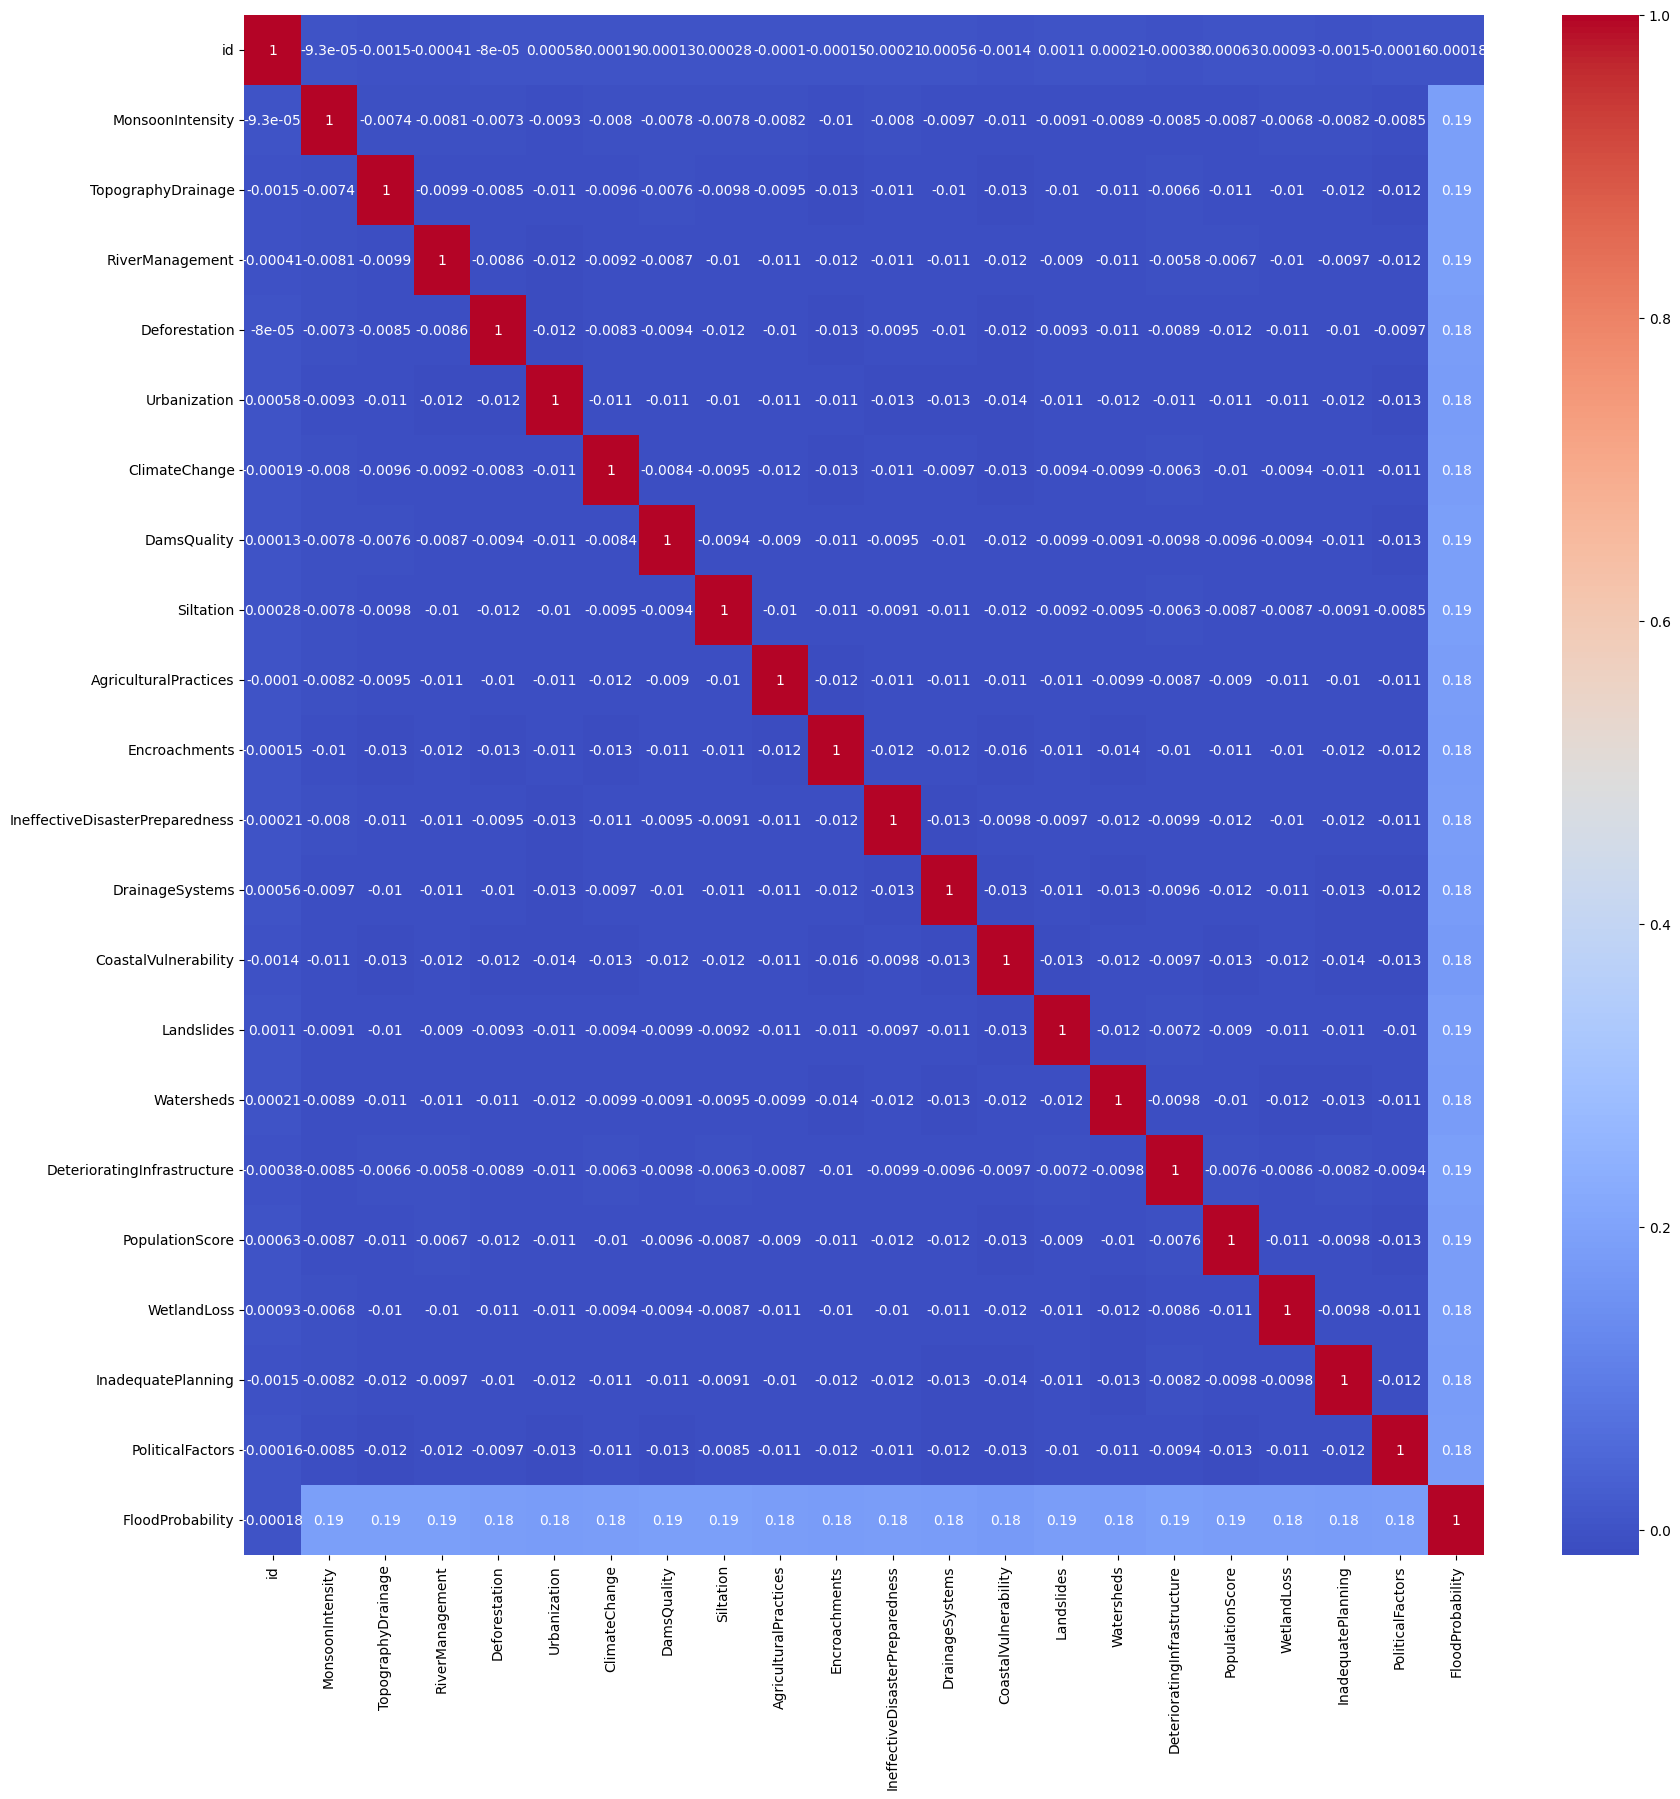

In [15]:
corr = train.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr,cmap='coolwarm',annot=True)
plt.show()

In [7]:
numeric_columns = train.select_dtypes(include=['float64','int64'])

def dist(train_dataset,columns,rows,cols):
    fig,ax = plt.subplots(rows,cols,figsize=(40,20))
    ax = ax.flatten()
    
    for i,col in enumerate(columns):
        sns.kdeplot(train_dataset[col],ax=ax[i],fill=True,alpha=0.5,linewidth=0.5,color='#058279', label='Train')
        ax[i].set_title(f"{col}, Train skewness {train_dataset[col].skew():.2f}")
        ax[i].legend()
        ax[i].axis('off')
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        median = train_dataset[col].median()
        ax[i].axvline(x=median,color='#4caba4', linestyle='--')
        ax[i].legend(labels=['Train', 'Median'])
        
    fig.suptitle('Distribution of Numeric Columns', fontsize=30)
    plt.tight_layout()
    sns.despine(left=True,bottom=True)

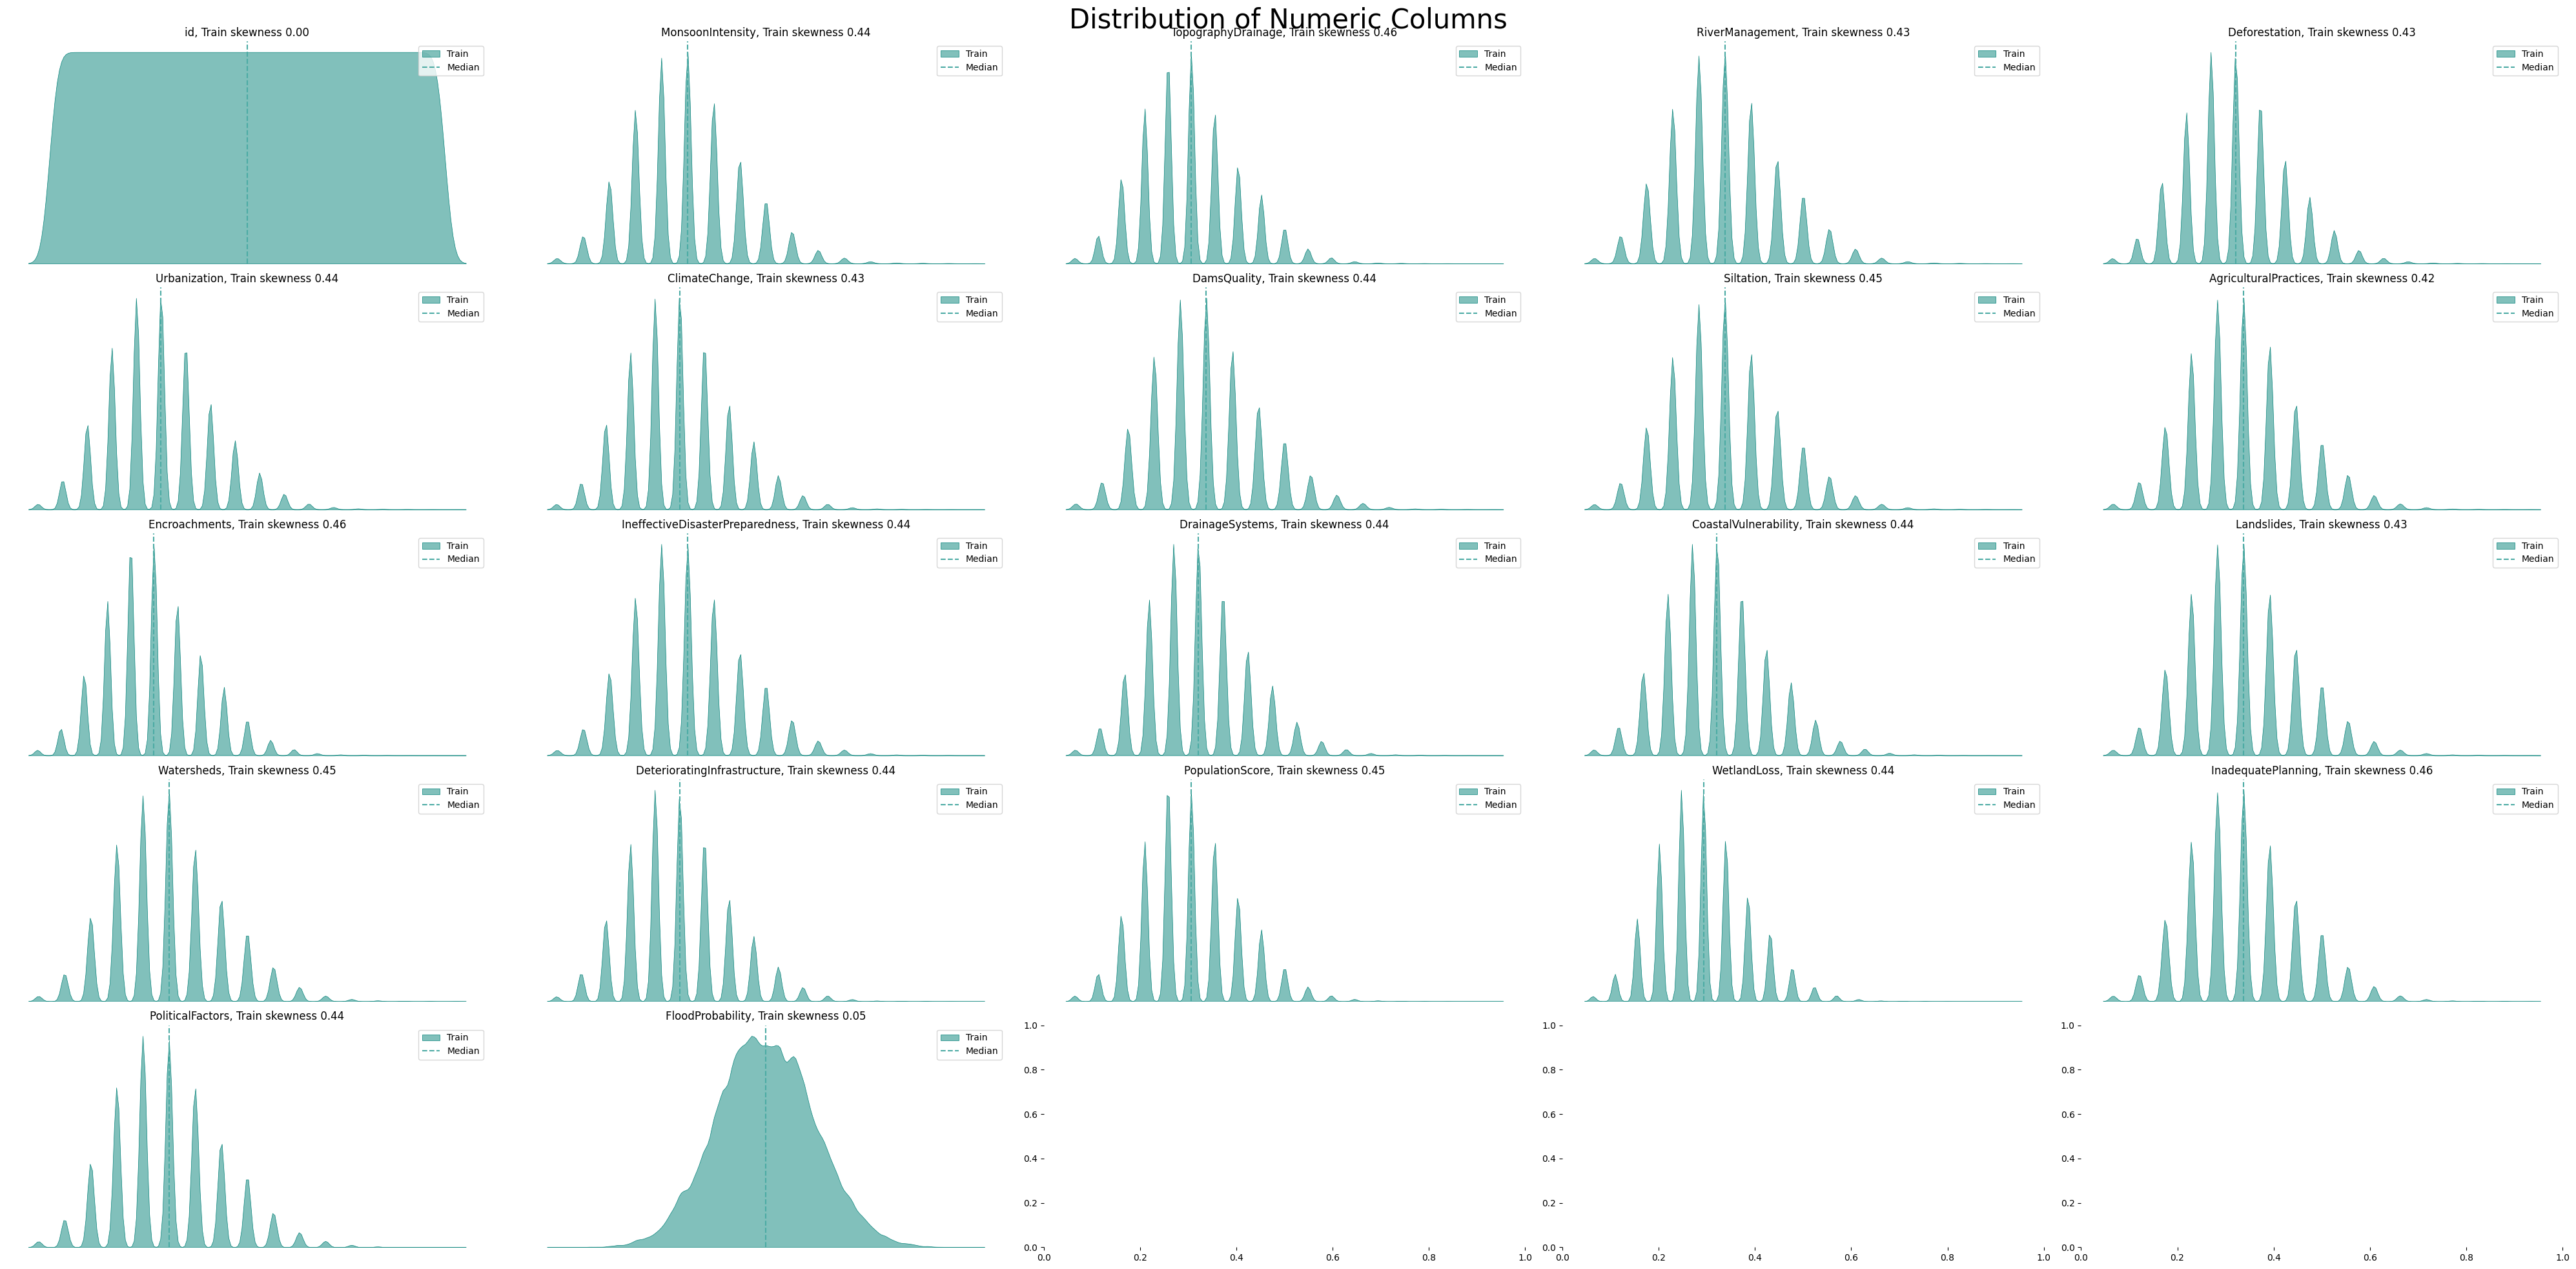

In [8]:
dist(train,columns=numeric_columns.columns,rows=5,cols=5)

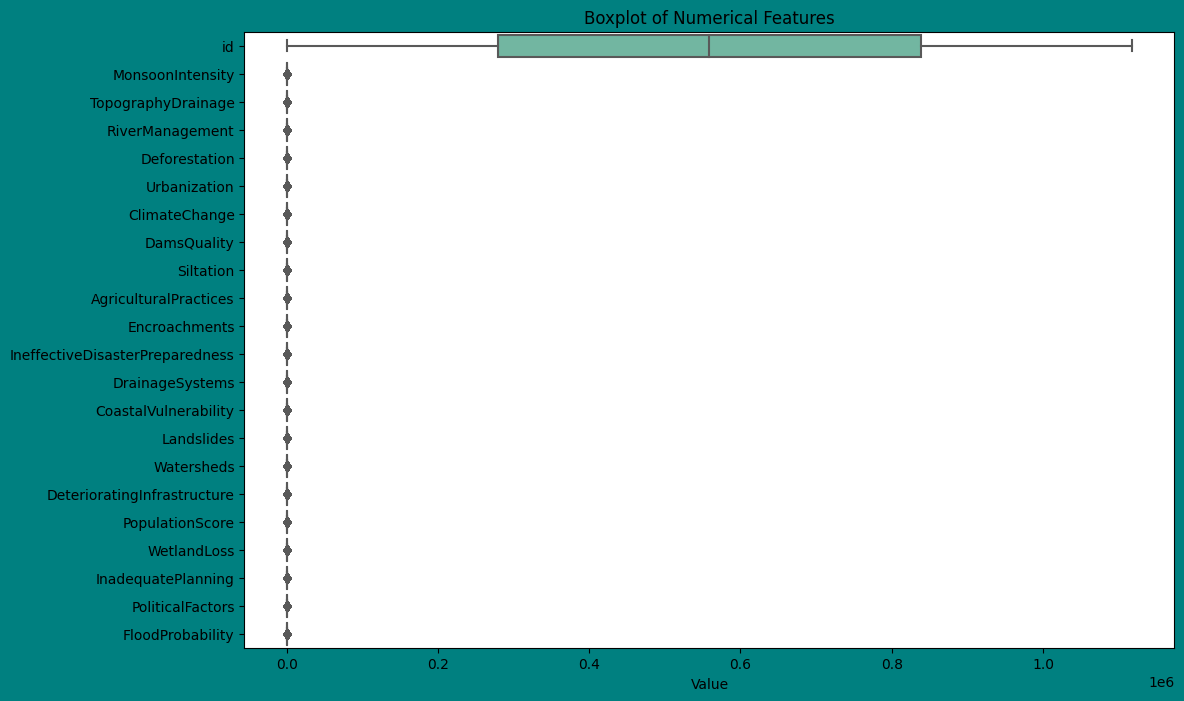

In [9]:
plt.figure(figsize=(12,8))
sns.boxplot(data=train[numeric_columns.columns],orient='h',palette='Set2')
plt.title('Boxplot of Numerical Features')
plt.xlabel('Value')
plt.gcf().set_facecolor('#008080')
plt.show()

In [10]:
test.isnull().sum()

id                                 0
MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
dtype: int64

In [7]:
y = train['FloodProbability']
X = train.drop(['FloodProbability'],axis=1)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape,X_test.shape

((894365, 20), (223592, 20))

In [13]:
y_train.shape

(894365,)

In [27]:
model = Sequential()
model.add(Dense(256,kernel_initializer='normal',input_dim=X_train.shape[1],activation='relu'))

model.add(Dense(512,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1,kernel_initializer='normal',activation='linear'))

model.compile(optimizer='adam',loss='mean_absolute_error',metrics=['mean_squared_error'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 256)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 268,545 (1.02 MB)

 Trainable params: 268,545 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
checkpoint_name = '/kaggle/working/Weights-{epoch:03d}--{val_loss:.5f}.keras' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [26]:
model.fit(X_train,y_train,batch_size=32,epochs=5,validation_data=(X_test,y_test),shuffle=True,
         callbacks=callbacks_list)

Epoch 1/5
27949/27949 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0262 - mean_squared_error: 0.0017
Epoch 1: val_loss did not improve from 0.01530
27949/27949 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - loss: 0.0262 - mean_squared_error: 0.0017 - val_loss: 0.0438 - val_mean_squared_error: 0.0025
Epoch 2/5
27928/27949 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0171 - mean_squared_error: 4.9273e-04
Epoch 2: val_loss did not improve from 0.01530
27949/27949 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - loss: 0.0171 - mean_squared_error: 4.9272e-04 - val_loss: 0.0387 - val_mean_squared_error: 0.0020
Epoch 3/5
27922/27949 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0168 - mean_squared_error: 4.8129e-04
Epoch 3: val_loss did not improve from 0.01530
27949/27949 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - loss: 0.0168 - mean_squared_error: 4.8129e-04 - val_loss: 0.0386 - val_mean_squared_error: 0.0020
Epoch 4/5
27929/27949 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0167 - mean_squared_error: 4.7683e-04
Epoch 4: val_loss

In [21]:
weights = '/kaggle/working/Weights-001--0.01554.keras'
model = keras.models.load_model(weights)

In [19]:
pred = model.predict(test)


23291/23291 [==============================] - 66s 3ms/step


In [22]:
pred2 = model.predict(X_test)

6988/6988 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


In [23]:
pred2

array([[0.5358357 ],
       [0.58757436],
       [0.52512366],
       ...,
       [0.53523517],
       [0.48971564],
       [0.5027849 ]], dtype=float32)

In [36]:
y_test

1105809    0.560
442591     0.575
5434       0.510
82966      0.530
584893     0.590
           ...  
17711      0.625
874414     0.560
390691     0.535
368042     0.530
776519     0.495
Name: FloodProbability, Length: 223592, dtype: float64

In [28]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, pred2)

print("R2 Score:", r2)


R2 Score: 0.8455325873394963


In [58]:
model = Sequential()
model.add(Dense(256,kernel_initializer='normal',input_dim=X_train.shape[1],activation='relu'))

model.add(Dense(256,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(5,kernel_initializer='normal',activation='sigmoid'))

model.compile(optimizer='adam',loss='mean_absolute_error',metrics=['mean_squared_error'])
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 256)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,245 (540.02 KB)

 Trainable params: 138,245 (540.02 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
model.fit(X_train,y_train,batch_size=32,epochs=2,validation_data=(X_test,y_test),shuffle=True,
         callbacks=callbacks_list)

Epoch 1/2
27949/27949 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0215 - mean_squared_error: 8.3784e-04
Epoch 1: val_loss did not improve from 0.01530
27949/27949 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - loss: 0.0215 - mean_squared_error: 8.3783e-04 - val_loss: 0.0296 - val_mean_squared_error: 0.0013
Epoch 2/2
27937/27949 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0163 - mean_squared_error: 4.5311e-04
Epoch 2: val_loss did not improve from 0.01530
27949/27949 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - loss: 0.0163 - mean_squared_error: 4.5311e-04 - val_loss: 0.0260 - val_mean_squared_error: 0.0010


In [60]:
pred3 = model.predict(X_train)
x_test_pred = model.predict(X_test)
test = model.predict(test)

27949/27949 ━━━━━━━━━━━━━━━━━━━━ 33s 1ms/step
6988/6988 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
23291/23291 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step


In [61]:
pred3

array([[0.5419306 , 0.5420747 , 0.5420258 , 0.5418055 , 0.54253376],
       [0.4002244 , 0.39995873, 0.40025797, 0.4002252 , 0.40024966],
       [0.48879114, 0.48883408, 0.4888641 , 0.4886991 , 0.48890957],
       ...,
       [0.42632562, 0.4260765 , 0.42637077, 0.4262594 , 0.4262866 ],
       [0.4728793 , 0.472833  , 0.47298166, 0.4727777 , 0.4728956 ],
       [0.45453477, 0.45438993, 0.4546815 , 0.45442957, 0.45446235]],
      dtype=float32)

In [62]:
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from xgboost import XGBRegressor



xgb_params ={'n_estimators':1200,
 'max_depth': 6,
 'learning_rate': 0.039987569,
 }

xgb_model = XGBRegressor(**xgb_params)

xgb_model.fit(pred3, y_train,
              eval_set=[(pred3, y_train), (x_test_pred, y_test)],
              early_stopping_rounds=10,
              verbose=100)

xgb_predictions = xgb_model.predict(x_test_pred) 
xgb_train_predictions = xgb_model.predict(pred3)
xgb_test = xgb_model.predict(test)

overall_metric_xgb = r2_score(y_test, xgb_predictions)
print("Overall R^2 (XGBRegressor):", overall_metric_xgb)


[0]	validation_0-rmse:0.04928	validation_1-rmse:0.04923
[100]	validation_0-rmse:0.01891	validation_1-rmse:0.01890
[171]	validation_0-rmse:0.01889	validation_1-rmse:0.01888
Overall R^2 (XGBRegressor): 0.8628332748119418


In [63]:
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

catboost_params ={'depth': 3,                   
                  'random_state':42,
                  'task_type': 'CPU', 
                  'eval_metric': 'RMSE', 
                  'min_data_in_leaf': 4, 
                  'loss_function': 'RMSE',
                  'grow_policy': 'Lossguide', 
                  'bootstrap_type': 'Bernoulli',
                  'subsample': 0.83862137638162, 
                  'l2_leaf_reg': 8.365422739510098, 
                  'random_strength': 3.296124856352495, 
                  'learning_rate': 0.0983, 
}

catboost_model = CatBoostRegressor(**catboost_params)

catboost_model.fit(pred3, y_train,
                   eval_set=(x_test_pred, y_test),
                   early_stopping_rounds=10)




0:	learn: 0.0468760	test: 0.0468268	best: 0.0468268 (0)	total: 121ms	remaining: 2m
1:	learn: 0.0432069	test: 0.0431582	best: 0.0431582 (1)	total: 225ms	remaining: 1m 52s
2:	learn: 0.0399194	test: 0.0398736	best: 0.0398736 (2)	total: 318ms	remaining: 1m 45s
3:	learn: 0.0370152	test: 0.0369701	best: 0.0369701 (3)	total: 414ms	remaining: 1m 43s
4:	learn: 0.0344678	test: 0.0344248	best: 0.0344248 (4)	total: 510ms	remaining: 1m 41s
5:	learn: 0.0322356	test: 0.0321980	best: 0.0321980 (5)	total: 603ms	remaining: 1m 39s
6:	learn: 0.0302914	test: 0.0302557	best: 0.0302557 (6)	total: 696ms	remaining: 1m 38s
7:	learn: 0.0286130	test: 0.0285789	best: 0.0285789 (7)	total: 789ms	remaining: 1m 37s
8:	learn: 0.0271482	test: 0.0271179	best: 0.0271179 (8)	total: 886ms	remaining: 1m 37s
9:	learn: 0.0258746	test: 0.0258455	best: 0.0258455 (9)	total: 980ms	remaining: 1m 37s
10:	learn: 0.0247925	test: 0.0247648	best: 0.0247648 (10)	total: 1.07s	remaining: 1m 36s
11:	learn: 0.0238652	test: 0.0238392	best: 0.

In [64]:
catboost_train_predictions = catboost_model.predict(pred3)
catboost_predictions = catboost_model.predict(x_test_pred)
catboost_test = catboost_model.predict(test)

overall_metric_catboost = r2_score(y_test, catboost_predictions)
print("Overall R^2 (CatBoostRegressor):", overall_metric_catboost)

Overall R^2 (CatBoostRegressor): 0.8628338236063124


In [65]:
from lightgbm import LGBMRegressor

# Parametere derived from here https://www.kaggle.com/code/thiagomantuani/ps4e5-flood-prediction-get-started
# One can get this using optuna, gris, random or baysein technique as well which will take time

lgbm_params = {
    'num_leaves': 183, 
    'learning_rate': 0.01183688880802108, 
    'n_estimators': 577, 
    'subsample_for_bin': 165697, 
    'min_child_samples': 114, 
    'reg_alpha': 2.075080888948164e-06, 
    'reg_lambda': 3.838938366471552e-07, 
    'colsample_bytree': 0.9634044234652241, 
    'subsample': 0.9592138618622019, 
    'max_depth': 9,
    'random_state':42,
    'verbose': -1
}

lgbm_model = LGBMRegressor(**lgbm_params)

lgbm_model.fit(pred3, y_train,
               eval_set=[(x_test_pred, y_test)],
               eval_metric='rmse')




LGBMRegressor(colsample_bytree=0.9634044234652241,
              learning_rate=0.01183688880802108, max_depth=9,
              min_child_samples=114, n_estimators=577, num_leaves=183,
              random_state=42, reg_alpha=2.075080888948164e-06,
              reg_lambda=3.838938366471552e-07, subsample=0.9592138618622019,
              subsample_for_bin=165697, verbose=-1)

In [66]:
lgbm_train_predictions = lgbm_model.predict(pred3)
lgbm_predictions = lgbm_model.predict(x_test_pred)
lgbm_test = lgbm_model.predict(test)

overall_metric_lgbm = r2_score(y_test, lgbm_predictions)
print("Overall R^2 (LGBMRegressor):", overall_metric_lgbm)

Overall R^2 (LGBMRegressor): 0.8628317488403744


In [67]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

stacked_train_features = np.column_stack((xgb_train_predictions, catboost_train_predictions, lgbm_train_predictions))
stacked_test_features = np.column_stack((xgb_predictions, catboost_predictions, lgbm_predictions))
stacked_test = np.column_stack((xgb_test, catboost_test, lgbm_test))

meta_estimator = RidgeCV()
meta_estimator.fit(stacked_train_features, y_train)

stacking_train_predictions = meta_estimator.predict(stacked_train_features)
stacking_test_predictions = meta_estimator.predict(stacked_test_features)
stacked_test_result = meta_estimator.predict(stacked_test)

overall_metric_stacking = r2_score(y_train, stacking_train_predictions)  
print("Overall R^2 (StackingRegressor):", overall_metric_stacking)

Overall R^2 (StackingRegressor): 0.8631822196293601


In [68]:

overall_metric_stacking = r2_score(y_test, stacking_test_predictions)  
print("Overall R^2 (StackingRegressor):", overall_metric_stacking)

Overall R^2 (StackingRegressor): 0.8629903745995571


In [70]:
stacked_test_result

array([0.57439984, 0.4518819 , 0.45202686, ..., 0.61725109, 0.54842897,
       0.52658123])

In [73]:
df =pd.DataFrame(stacked_test_result,columns=['FloodProbability'])

In [74]:
df.head()

FloodProbability
0          0.574400
1          0.451882
2          0.452027
3          0.471806
4          0.472228

In [78]:
file = pd.read_csv('/kaggle/input/flood-dataset/test.csv')


In [82]:
file = file['id']

In [86]:
appended_df = pd.concat([file, df], ignore_index=True,axis=1)

In [91]:
appended_df.head()

id  FloodProbability
0  1117957          0.574400
1  1117958          0.451882
2  1117959          0.452027
3  1117960          0.471806
4  1117961          0.472228

In [90]:
appended_df.rename(columns={0: 'id', 1: 'FloodProbability'}, inplace=True)


In [92]:
appended_df.to_csv('submission.csv', index=False)

In [77]:
df.shape

(745305, 1)